In [67]:
from pylab import *
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import *
from scipy.integrate import quad
from qutip import *

# CZ-gate on two Qutrits

Create annihilation and creation operators for qutrit system

In [68]:
# energy levels
N = 3 # Qutrit

# Annihilation operators for the two qutrits
a2 = tensor(qeye(N), destroy(N))
a1 = tensor(destroy(N), qeye(N))

### Qutrit parameters
| | qb1 | qb2 |
|:---:|:---:|:---:|
| Frequency (GHz) | 5.708390 | 5.202204 |
| Anharmonicty (GHz) | -0.261081457 | -0.275172227 |

### Coupling parameters

| | qb1-qb2 |
|:---:|:---:|
| Coupling (GHz) | 0.0038 |

### CZ-gate parameters

|    | Description | qb1-qb2 |
|:------:|:---:|:---:|
| $\frac{\omega_n}{2\pi}$ (GHz)      | sweet spot freq. | 5.708 (Upper) |
| $d$ | Josephson Junction asymmetry | 0.78 |
| $C$ ($\Phi_0$/V) | conversion constant | 0.47703297 |
| $\phi$ ($\Phi_0$) | offset | 0 |
| $a$ (V) | amplitude for CZ-gate | 1.44 |
| $l$(ns) | length for CZ-gate | 96.00 |
| $\sigma$ (ns) | Gaussian filter std. | 1.00 |
| $b$ (ns) | buffer length | 15 |

In [69]:
# Anharmonicity in (GHz)
alpha_2 = - 2*np.pi * 0.275172227
alpha_1 = - 2*np.pi * 0.261081457

# Qubit frequency in (GHz)
omega_2 = 2*np.pi * 5.202204
omega_1 = 2*np.pi * 5.708390

# Coupling in (GHz)
J = 2*pi * 3.8*1e-3

# Offset (Flux quantum h/(2e)) 
phi_0 = 0

# Josephson Junction asymmetry
d = 0.78

# Length of CZ gate in (ns)
L = 96.00

# Gaussian filter st.d in (ns)
sigma = 1.00

# Buffer length in (ns)
b = 15

# Conversion constant (Flux quantum / V)
C = 0.47703297

# Amplitude of square pulse in (V)
a = 1.46

### Prepare Hamiltonian
The Hamiltonian of system is $H$.
$$
H = H_\textrm{qubits}+H_\textrm{coupling} = \omega_1 a_1^\dagger a_1 + \frac{\alpha_1}{2} a_1^{\dagger 2}a_1^2 + \omega_2 a_2^\dagger a_2 + \frac{\alpha_2}{2} a_2^{\dagger 2}a_2^2 + J(a_1^\dagger a_2 + a_2^\dagger a_1) 
$$

In [70]:
# Transmon Hamiltonian
H_qubits = omega_1 * a1.dag() * a1 + alpha_1/2 * pow(a1.dag(),2) * pow(a1,2) \
+ omega_2 * a2.dag() * a2 + alpha_2/2 * pow(a2.dag(),2) * pow(a2,2)

# Coupling
H_coupling = J*(a1.dag()*a2 + a2.dag()*a1)

# Time independent Hamiltonian
H = H_qubits + H_coupling

### Two qubit gate
The two qubit gates are performed by the pulse Hamiltonian
$$
H_1=-\Delta(t)a_1^\dagger a_1
$$
With
$$
\Delta(t) = \left(\omega_1 - \omega_1\sqrt[4]{\cos(\Phi(t)+\phi_0)^2+d^2\sin(\Phi(t)+\phi_0)^2}\right)
$$
With the pulse shape:
$$
\Phi(t) = C\cdot\left(A(t)*f(t)\right),
$$

Where $A(t)$ is a square pulse of length $l$ and amplitude $a$ and $f(t)$ is a gaussian with a mean taht is centered at the square pulse and sigma $\sigma$.

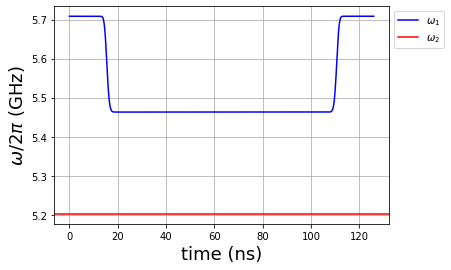

In [71]:
# Pulse shape
def Phi(t):
    
    # Square pulse of length L and amplitude a centered at (b+L/2)
    A = a * (heaviside(t - b, 0) - heaviside(t - (L+b), 0))
    
    # Gaussian with mean (b+L/2) and std sigma
    f = np.exp(-pow(t-(b+L/2),2)/(2*pow(sigma,2)))
 
    return C * np.convolve(A, f, mode = 'same') / np.sum(f)

# Flux tuning of qubit 1
def Delta(t):
    return omega_1 - omega_1 * pow(np.cos(Phi(t)+phi_0)**2 + d**2*np.sin(Phi(t)+phi_0)**2,1/4)

# Total time in (ns)
t_total = L + 2*b
tlist = np.linspace(0, t_total, 1000)

# Plot the frequency tuning of qubit 1 as a function of time
fig, ax = plt.subplots()
ax.plot(tlist, (omega_1-Delta(tlist))/(2*np.pi), color='b',label=r'$\omega_1$') # qubit1 frequency
ax.axhline(y = (omega_2)/(2*np.pi), color='r',label=r'$\omega_2$') # qubit2 frequency

plt.xlabel(r'time (ns)',fontsize=18)
plt.ylabel(r'$\omega/2\pi$ (GHz)',fontsize=18)

legend = ax.legend(loc = 'upper right', shadow=True)
ax.legend(bbox_to_anchor = (1,1), loc="upper left")

plt.grid()

### Total Hamiltonian

In [72]:
# Time dependent Hamiltonian
H1 = a1.dag() * a1
H1_coeff = - Delta(tlist)

H_total = QobjEvo([H, [H1, H1_coeff]], tlist = tlist)

### Evolution of energy levels

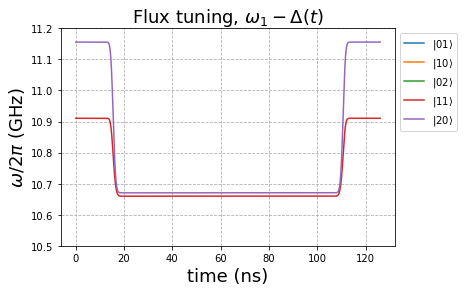

In [73]:
# Allocate array to memory
E = np.zeros([N**2,len(tlist)])

# Diagonalize the Hamiltonian for each time step
for i in range(len(tlist)):
    E[:,i] = (H + H1_coeff[i] * H1).eigenenergies()

# Plot ωnm = (Enm − E00)
fig, ax = plt.subplots()

ax.plot(tlist,(E[1,:]-E[0,:])/(2*np.pi),label=r'$|01\rangle$') # 01
ax.plot(tlist,(E[2,:]-E[0,:])/(2*np.pi),label=r'$|10\rangle$') # 10
ax.plot(tlist,(E[3,:]-E[0,:])/(2*np.pi),label=r'$|02\rangle$') # 02
ax.plot(tlist,(E[4,:]-E[0,:])/(2*np.pi),label=r'$|11\rangle$') # 11
ax.plot(tlist,(E[5,:]-E[0,:])/(2*np.pi),label=r'$|20\rangle$') # 20

ax.set_ylim(10.5,11.2)

plt.title(r'Flux tuning, $\omega_1-\Delta(t)$',fontsize=18)
plt.xlabel(r'time (ns)',fontsize=18)
plt.ylabel(r'$\omega/2\pi$ (GHz)',fontsize=18)

legend = ax.legend(loc = 'upper right', shadow=True)
ax.legend(bbox_to_anchor = (1,1), loc="upper left")

ax.grid(linestyle='--')
plt.show()

In [74]:
# Energy levels at t = 0
print('E_01 =',omega_2/(2*np.pi))             # 01
print('E_10 =',omega_1/(2*np.pi))             # 10
print('E_11 =',(omega_1+omega_2)/(2*np.pi))   # 11
print('E_20 =',(2*omega_1+alpha_1)/(2*np.pi)) # 20
print('E_02 =',(2*omega_2+alpha_2)/(2*np.pi)) # 02

E_01 = 5.202204
E_10 = 5.70839
E_11 = 10.910593999999998
E_20 = 11.155698543
E_02 = 10.129235773000001


In [75]:
# Energies at t=60 ns
print('E_11 =',(E[5,500]-E[0,500])/(2*np.pi)) # 11
print('E_20 =',(E[4,500]-E[0,500])/(2*np.pi)) # 20
print('E_02 =',(E[3,500]-E[0,500])/(2*np.pi)) # 02

E_11 = 10.670510139305016
E_20 = 10.659758224439466
E_02 = 10.129181892287738


In [76]:
(E[5,500] - E[4,500])/(2*np.pi)*1000

10.751914865549208

### State Simulation

In [172]:
# initial state |11⟩
psi = tensor(basis(N,1),basis(N,1))

# For precise calculation
opt = Options(nsteps=2500, atol=1e-10, rtol=1e-8)

# Collapse operators
c_ops = []

# Master equation simulation
result = mesolve(H_total, psi, tlist, c_ops, [], options = opt, progress_bar=True)
rho = result.states

10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.19s. Est. time left: 00:00:00:00
30.0%. Run time:   0.29s. Est. time left: 00:00:00:00
40.0%. Run time:   0.38s. Est. time left: 00:00:00:00
50.0%. Run time:   0.47s. Est. time left: 00:00:00:00
60.0%. Run time:   0.55s. Est. time left: 00:00:00:00
70.0%. Run time:   0.64s. Est. time left: 00:00:00:00
80.0%. Run time:   0.73s. Est. time left: 00:00:00:00
90.0%. Run time:   0.81s. Est. time left: 00:00:00:00
Total run time:   0.91s


### Rabi oscillations

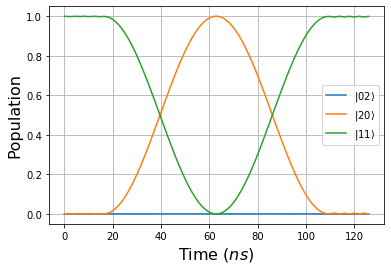

In [199]:
exp_20 = expect(tensor(fock_dm(N,2),fock_dm(N,0)),rho) # population in |20⟩
exp_02 = expect(tensor(fock_dm(N,0),fock_dm(N,2)),rho) # population in |02⟩
exp_11 = expect(tensor(fock_dm(N,1),fock_dm(N,1)),rho) # population in |11⟩

plt.plot(tlist, exp_02, label=r'$|02\rangle$')
plt.plot(tlist, exp_20, label=r'$|20\rangle$')
plt.plot(tlist, exp_11, label=r'$|11\rangle$')

plt.xlabel('Time ($ns$)',fontsize=16)
plt.ylabel('Population',fontsize=16)

plt.legend()
plt.grid()

### Fidelity

In [215]:
rotate_U = (1j*H_qubits*t_total).expm()

# Move into transmon frame
transmon_state = rotate_U*rho[-1]

# project onto qubit subspace
qubit_state = (tensor(basis(2,0),basis(2,0))*tensor(basis(3,0),basis(3,0)).dag() \
               + tensor(basis(2,1),basis(2,1))*tensor(basis(3,1),basis(3,1)).dag() \
               + tensor(basis(2,0),basis(2,1))*tensor(basis(3,0),basis(3,1)).dag() \
               + tensor(basis(2,1),basis(2,0))*tensor(basis(3,1),basis(3,0)).dag())*transmon_state

# normalize
qubit_state = qubit_state / qubit_state.norm()

# target state -|11⟩
target_state = -tensor(basis(2,1),basis(2,1))

# fidelity
fid = fidelity(qubit_state,target_state)
print('Fidelity =',round(fid,4))

Fidelity = 1.0


### Cancel the phase angles
During the evolution the other states pick up some dynamical phases, that we need to cancel
$$
U(t) = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{-i\alpha} & 0 & 0 \\
0 & 0 & e^{-i\beta} & 0 \\
0 & 0 & 0 & -e^{-i(\alpha+\beta)}
\end{pmatrix}
$$
where
$$
\alpha=\int_0^{t_\mathrm{gate}}E_{01} dt, \quad \beta=\int_0^{t_\mathrm{gate}}E_{10} dt
$$
Ref: https://arxiv.org/abs/1301.1719v1

In [216]:
# alpha
E01 = E[1,:]-E[0,:]
alpha = np.trapz(E01,tlist)

# beta
E10 = E[2,:]-E[0,:]
beta = np.trapz(E10,tlist)

### Qubit state

In [218]:
np.exp(-1j*(alpha+beta))*qubit_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.91800442+0.39657016j]]

### Calculate quantum map
Calculate the propagator $U(t)$ for the density matrix or wave function such that $\psi(t) = U(t)\psi(0)$ or $\rho_{\mathrm vec}(t) = U(t) \rho_{\mathrm vec}(0)$ where $\rho_{\mathrm vec}$ is the vector representation of the density matrix.

In [205]:
# For precise calculation
opt = Options(nsteps=2500, atol=1e-10, rtol=1e-8)

# Collapse operators
c_ops = []

# Propagator
prop = propagator(H_total.to_list(), tlist, c_ops, options = opt, progress_bar = True)

In [206]:
qubit_state = Qobj([transmon_state.data[i,0] for i in [0,1,3,4]], dims = [[2,2],[1,1]], shape=(4,1))

### Calculate quantum map in rotating frame

In [207]:
# unitary matrix to into transmon frame
rotate_U = (1j*H_qubits*t_total).expm()
rotate_prop = rotate_U * prop[-1] * rotate_U.dag()

In [212]:
# Prepare the numbers of rows and columns to extract
l = [0,1,3,4]

# Extracted quantum map
q_map = Qobj([[rotate_prop.data[b,i] for j,i in enumerate(l)] for a,b in enumerate(l)], dims = [[2,2],[2,2]])

# Cancel phase angles
q_map.data[1,1] = q_map.data[1,1]*np.exp(1j*alpha)
q_map.data[2,2] = q_map.data[2,2]*np.exp(1j*beta)
q_map.data[3,3] = q_map.data[3,3]*np.exp(1j*(alpha+beta))

### Calculate average gate fidelity

In [213]:
# Target
cz = cphase(np.pi)

# Average gate fidelity
avg_fid = average_gate_fidelity(q_map, cz)
print("Average gate fidelity is %s %%" % round(avg_fid*100,4))

Average gate fidelity is 99.8886 %


### Quantum map

In [214]:
q_map#*tensor(basis(2,1),basis(2,1))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.99983802+3.05382195e-06j
  -0.00135715+1.79467493e-02j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.00886331-1.56642732e-02j
   0.99983802-2.77343871e-06j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.99678689-7.74665025e-02j]]

### Version

In [122]:
import qutip.ipynbtools
qutip.ipynbtools.version_table()

Software,Version
QuTiP,4.5.0.dev0+9f718cc3
Numpy,1.17.3
SciPy,1.3.2
matplotlib,3.1.2
Cython,0.29.14
Number of CPUs,6
BLAS Info,Generic
IPython,7.10.1
Python,"3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:19) [Clang 9.0.0 (tags/RELEASE_900/final)]"
OS,posix [darwin]
